## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [142]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

# 1. camera calibration -> mtx, dist pars
# 2. distorsion correction 
# 3. binarization 
# 4. perspective transform

# 5. lane pixel detection
#    5.1 lane pixel region selection
#    5.2 polyfit

# 6. fitted lines unwrap
# 7. output visual image and curvature position

##################################################################
#   1. CAMERA CALIBRATION
##################################################################
def camera_calibration():
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob('camera_cal/calibration*.jpg')

    # Step through the list and search for chessboard corners
    limg = lgray = None
    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            # Draw and display the corners
            img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
            #cv2.imshow('img',img)
            #cv2.waitKey(500)
            limg = img
            lgray = gray

    #We calculate the distorsion pars and matrix
    return cv2.calibrateCamera(objpoints, imgpoints, lgray.shape[::-1], None, None)

ret, mtx, dist, rvecs, tvecs = camera_calibration()

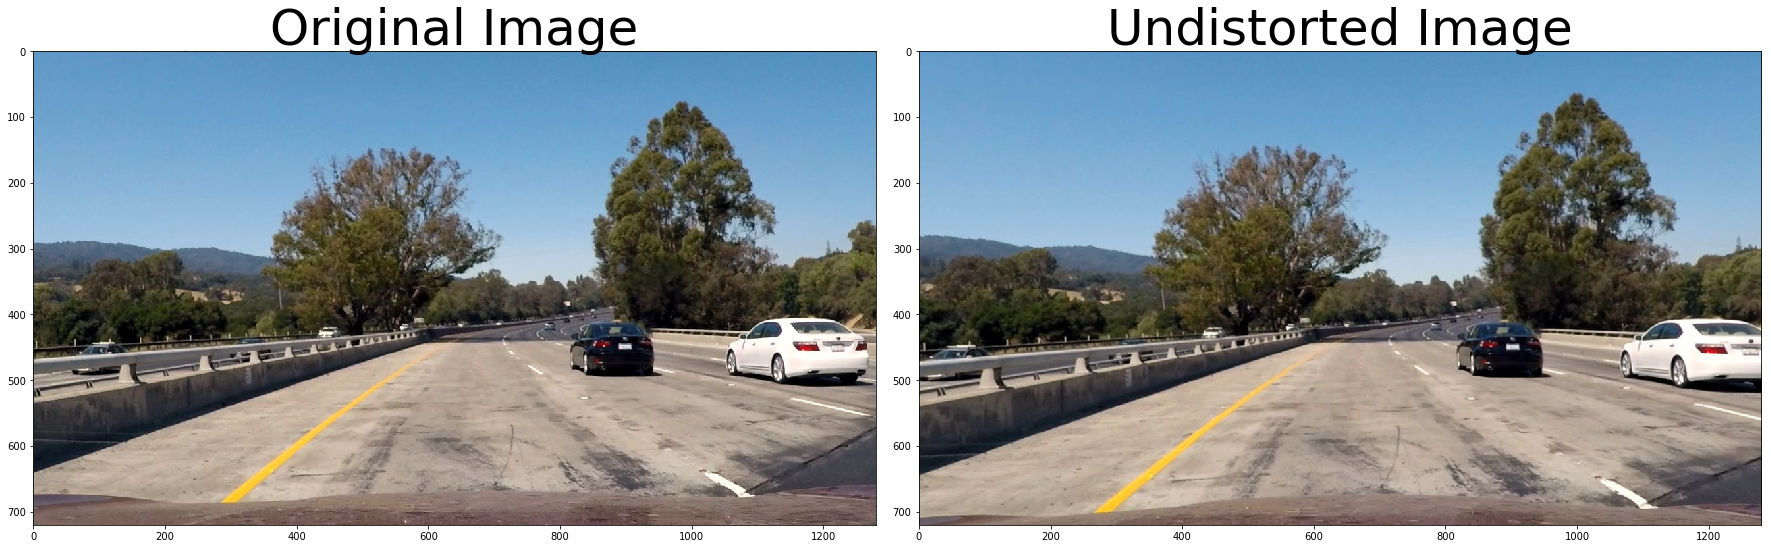

In [144]:
##################################################################
#   2. DISTORSION CORRECTION
##################################################################
#testimg = cv2.imread("./test_images/test1.jpg")  #will read in BGR mode
#testimg = cv2.cvtColor(testimg, cv2.COLOR_BGR2RGB)
testimg = mpimg.imread("test_images/test1.jpg")

def img_undistort(img, mtx, dist):
    return cv2.undistort( img, mtx, dist, None, mtx)

#test
undist = img_undistort( testimg, mtx, dist )
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(testimg)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undist)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)





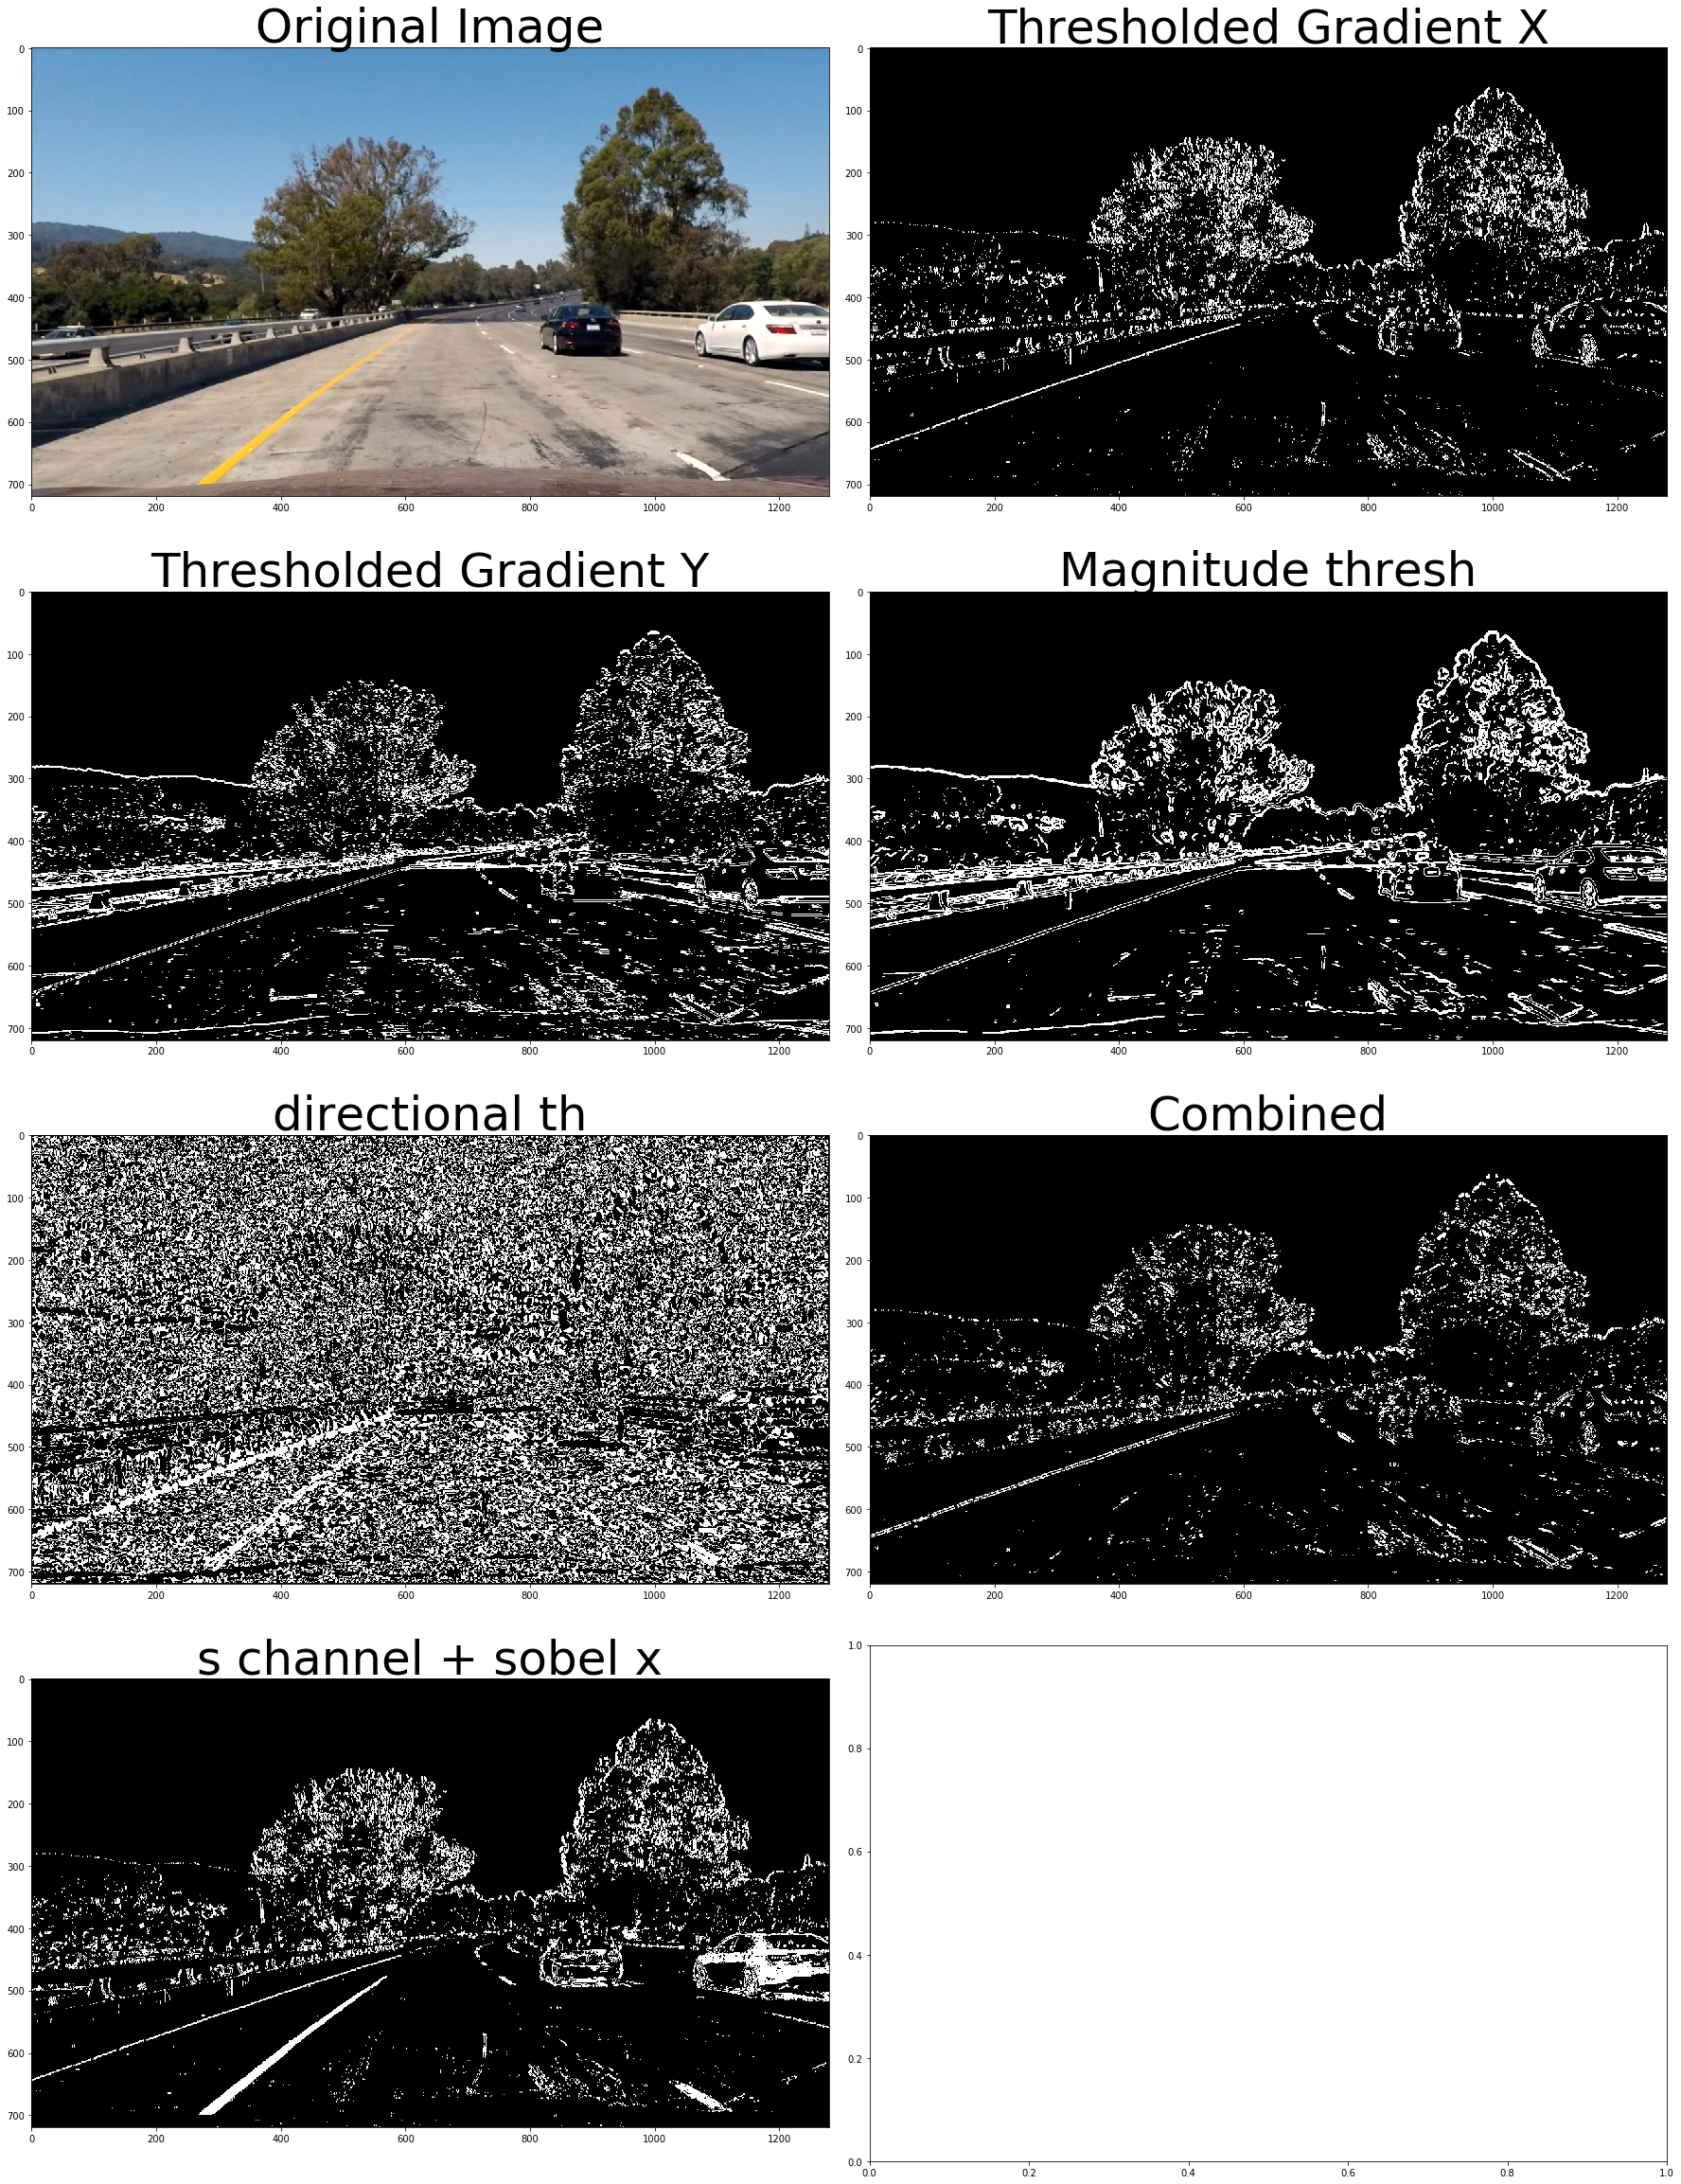

In [145]:
##################################################################
#   3. BINARIZATION 
##################################################################

# absolute sobel 
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0,255)):
    gray = cv2.cvtColor( img, cv2.COLOR_RGB2GRAY )
    k = [1,0] if orient=='x' else [0,1]
    sobel = cv2.Sobel(gray, cv2.CV_64F, *k, ksize=sobel_kernel)
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    sbinary = np.zeros_like(scaled_sobel)
    sbinary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1] )] = 1
    return sbinary

# magnitude threshold
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # 1) Convert to grayscale
    gray = cv2.cvtColor( img, cv2.COLOR_RGB2GRAY )
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Calculate the magnitude 
    abs_sobelxy = np.sqrt(sobelx**2 + sobely**2)
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    abs_sobel_scaled = np.uint8(255*abs_sobelxy/np.max(abs_sobelxy))
    # 5) Create a binary mask where mag thresholds are met
    sbinary = np.zeros_like(abs_sobel_scaled)
    sbinary[ (abs_sobel_scaled >= mag_thresh[0]) & (abs_sobel_scaled <= mag_thresh[1]) ] = 1
    # 6) Return this mask as your binary_output image
    return sbinary

#direction of threshold
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # 1) Convert to grayscale
    gray = cv2.cvtColor( img, cv2.COLOR_RGB2GRAY )
    # 2) x,y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    dirgrad = np.arctan2( np.absolute(sobely), np.absolute(sobelx) )
    # 5) Create a binary mask where direction thresholds are met
    binary_out = np.zeros_like(dirgrad)
    binary_out[ (dirgrad>=thresh[0]) & (dirgrad<=thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return binary_out

# Edit this function to create your own pipeline.
def s_and_sobelx_th(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(color_binary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    return combined_binary
    
# Apply each of the thresholding functions
def sobel_combined(img):
    gradx = abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(20, 100))
    grady = abs_sobel_thresh(img, orient='y', sobel_kernel=3, thresh=(20, 100))
    mag_binary = mag_thresh(img, sobel_kernel=9, mag_thresh=(30, 100))
    dir_binary = dir_threshold(img, sobel_kernel=15, thresh=(0.7, 1.3))

    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    return combined, gradx, grady, mag_binary, dir_binary

(combined,gradx, grady, mag_binary, dir_binary) = sobel_combined(undist)


def thresholding(img):
    return s_and_sobelx_th(img)





# Plot the result
f, axes = plt.subplots(4, 2, figsize=(24, 35))
f.tight_layout()
axes[0][0].imshow(undist)
axes[0][0].set_title('Original Image', fontsize=50)
axes[0][1].imshow(gradx, cmap='gray')
axes[0][1].set_title('Thresholded Gradient X', fontsize=50)

axes[1][0].imshow(grady, cmap='gray')
axes[1][0].set_title('Thresholded Gradient Y', fontsize=50)
axes[1][1].imshow(mag_binary, cmap='gray')
axes[1][1].set_title('Magnitude thresh', fontsize=50)

axes[2][0].imshow(dir_binary, cmap='gray')
axes[2][0].set_title('directional th', fontsize=50)
axes[2][1].imshow(combined, cmap='gray')
axes[2][1].set_title('Combined', fontsize=50)

axes[3][0].imshow(s_and_sobelx_th(undist), cmap='gray')
axes[3][0].set_title('s channel + sobel x', fontsize=50)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

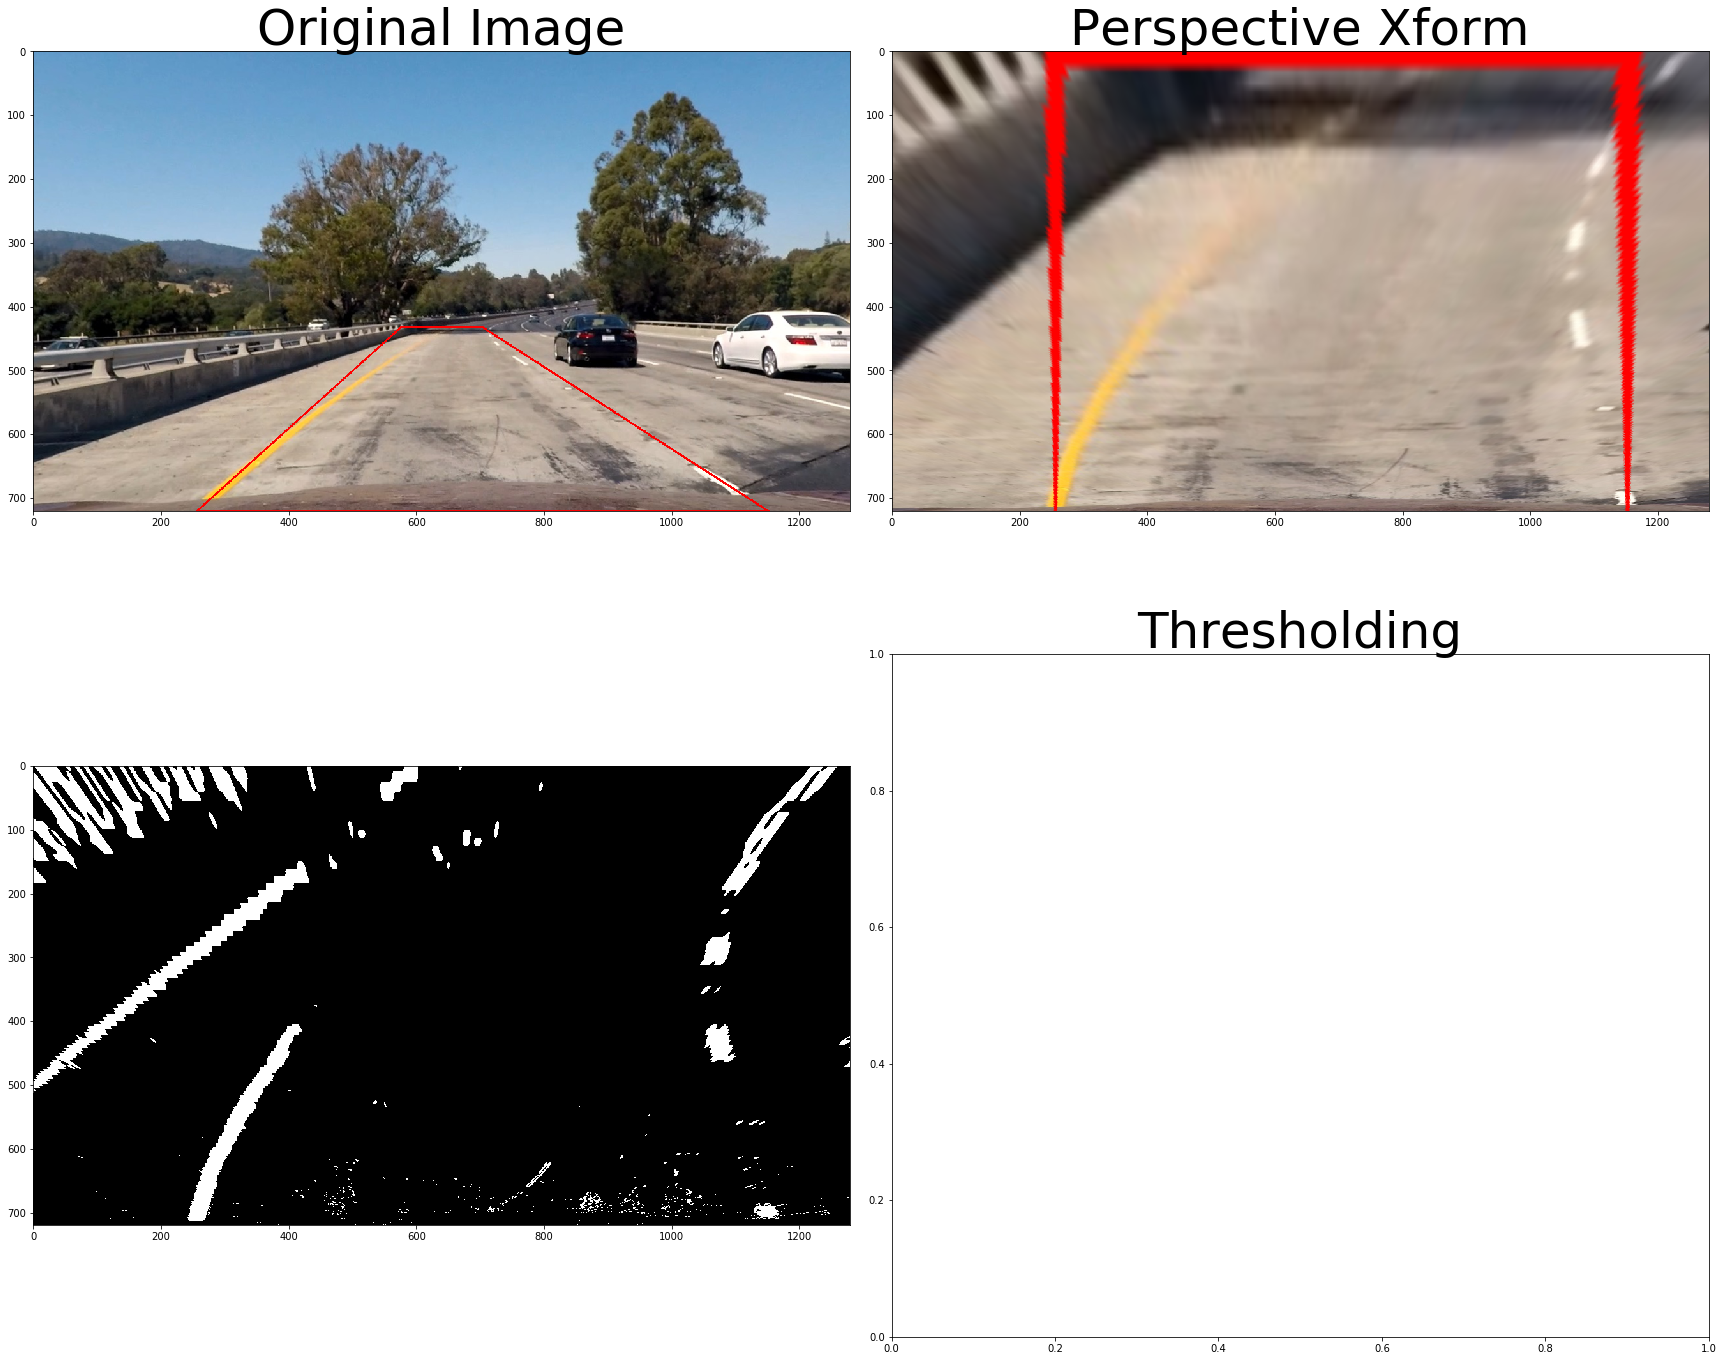

In [169]:
##################################################################
#   4. PERSPECTIVE TRANSFORM 
##################################################################

pers = undist.copy()

h,w= pers.shape[0:2]

a, b, c, d = [[0.45*w, 0.6*h],[0.55*w, 0.6*h],  [0.9*w,h],  [(0.2*w),h] ]
src = np.float32([a,b,c,d])

# For destination points, I'm arbitrarily choosing some points to be
# a nice fit for displaying our warped result 
# again, not exact, but close enough for our purposes
dst = np.float32([[d[0],0],[c[0],0],c,d])

pts = np.int32(src)
pts = pts.reshape(-1,1,2)
cv2.polylines(pers, [pts], True, (255,0,0), thickness=2)

# Given src and dst points, calculate the perspective transform matrix
M = cv2.getPerspectiveTransform(src, dst)

# Warp the image using OpenCV warpPerspective()
warped_w_lines = cv2.warpPerspective(pers, M, (undist.shape[1], undist.shape[0]))
warped = cv2.warpPerspective(thresholding(undist), M, (undist.shape[1], undist.shape[0]))
binary_warped = np.zeros_like(warped)
binary_warped[warped>0.5] = 1
binary_warped = binary_warped[:,:,0]

f, axes = plt.subplots(2, 2, figsize=(24, 20))
f.tight_layout()
axes[0][0].imshow(pers)
axes[0][0].set_title('Original Image', fontsize=50)
axes[0][1].imshow(warped_w_lines, cmap='gray')
axes[0][1].set_title('Perspective Xform', fontsize=50)

axes[1][0].imshow(binary_warped, cmap='gray')
axes[1][1].set_title('Thresholding', fontsize=50)

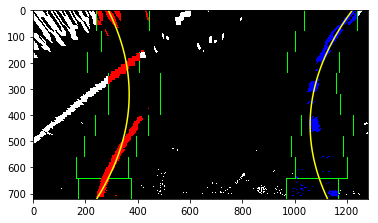

In [217]:
##################################################################
#   5. LANE DETECTION 
##################################################################
def find_lines(binary_warped):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    out_img = np.uint8( out_img )
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),color=(0,255,0), thickness=2 )
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
            

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    
    plt.imshow(out_img)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    
find_lines(binary_warped)